# **Import libraries**

In [53]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import math
import networkx as nx
import matplotlib.patches as mpatches

# **Load Car evaluation data**

In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/static/public/19/data.csv')
print("Dataset Head:")
print(df.head())

Dataset Head:
  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc


# Exploratory data analysis

## Data characteristics

In [25]:
# Display basic information about the dataset
print("Basic Information:")
df.info()

# Display the first few rows
print("\nFirst Five Rows:")
print(df.head())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display column names
print("\nColumn Names:")
print(df.columns)

# Display unique values in each column
print("\nUnique Entries:")
for col in df:
    print(col)
    print(df[col].unique())
    print('\n')

# Display the frequency of each unique values in each column
print("\nFrequency of Unique Entries:")
for col in df:
    print(f"\nFrequency of values in {col}:")
    print(df[col].value_counts())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB

First Five Rows:
  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc

Summary Statistics:
       buying  maint doors persons lug_boot safety  class
count    1728   1728  1728    1728     1728   1728   1728
unique      4      

## Visualize data

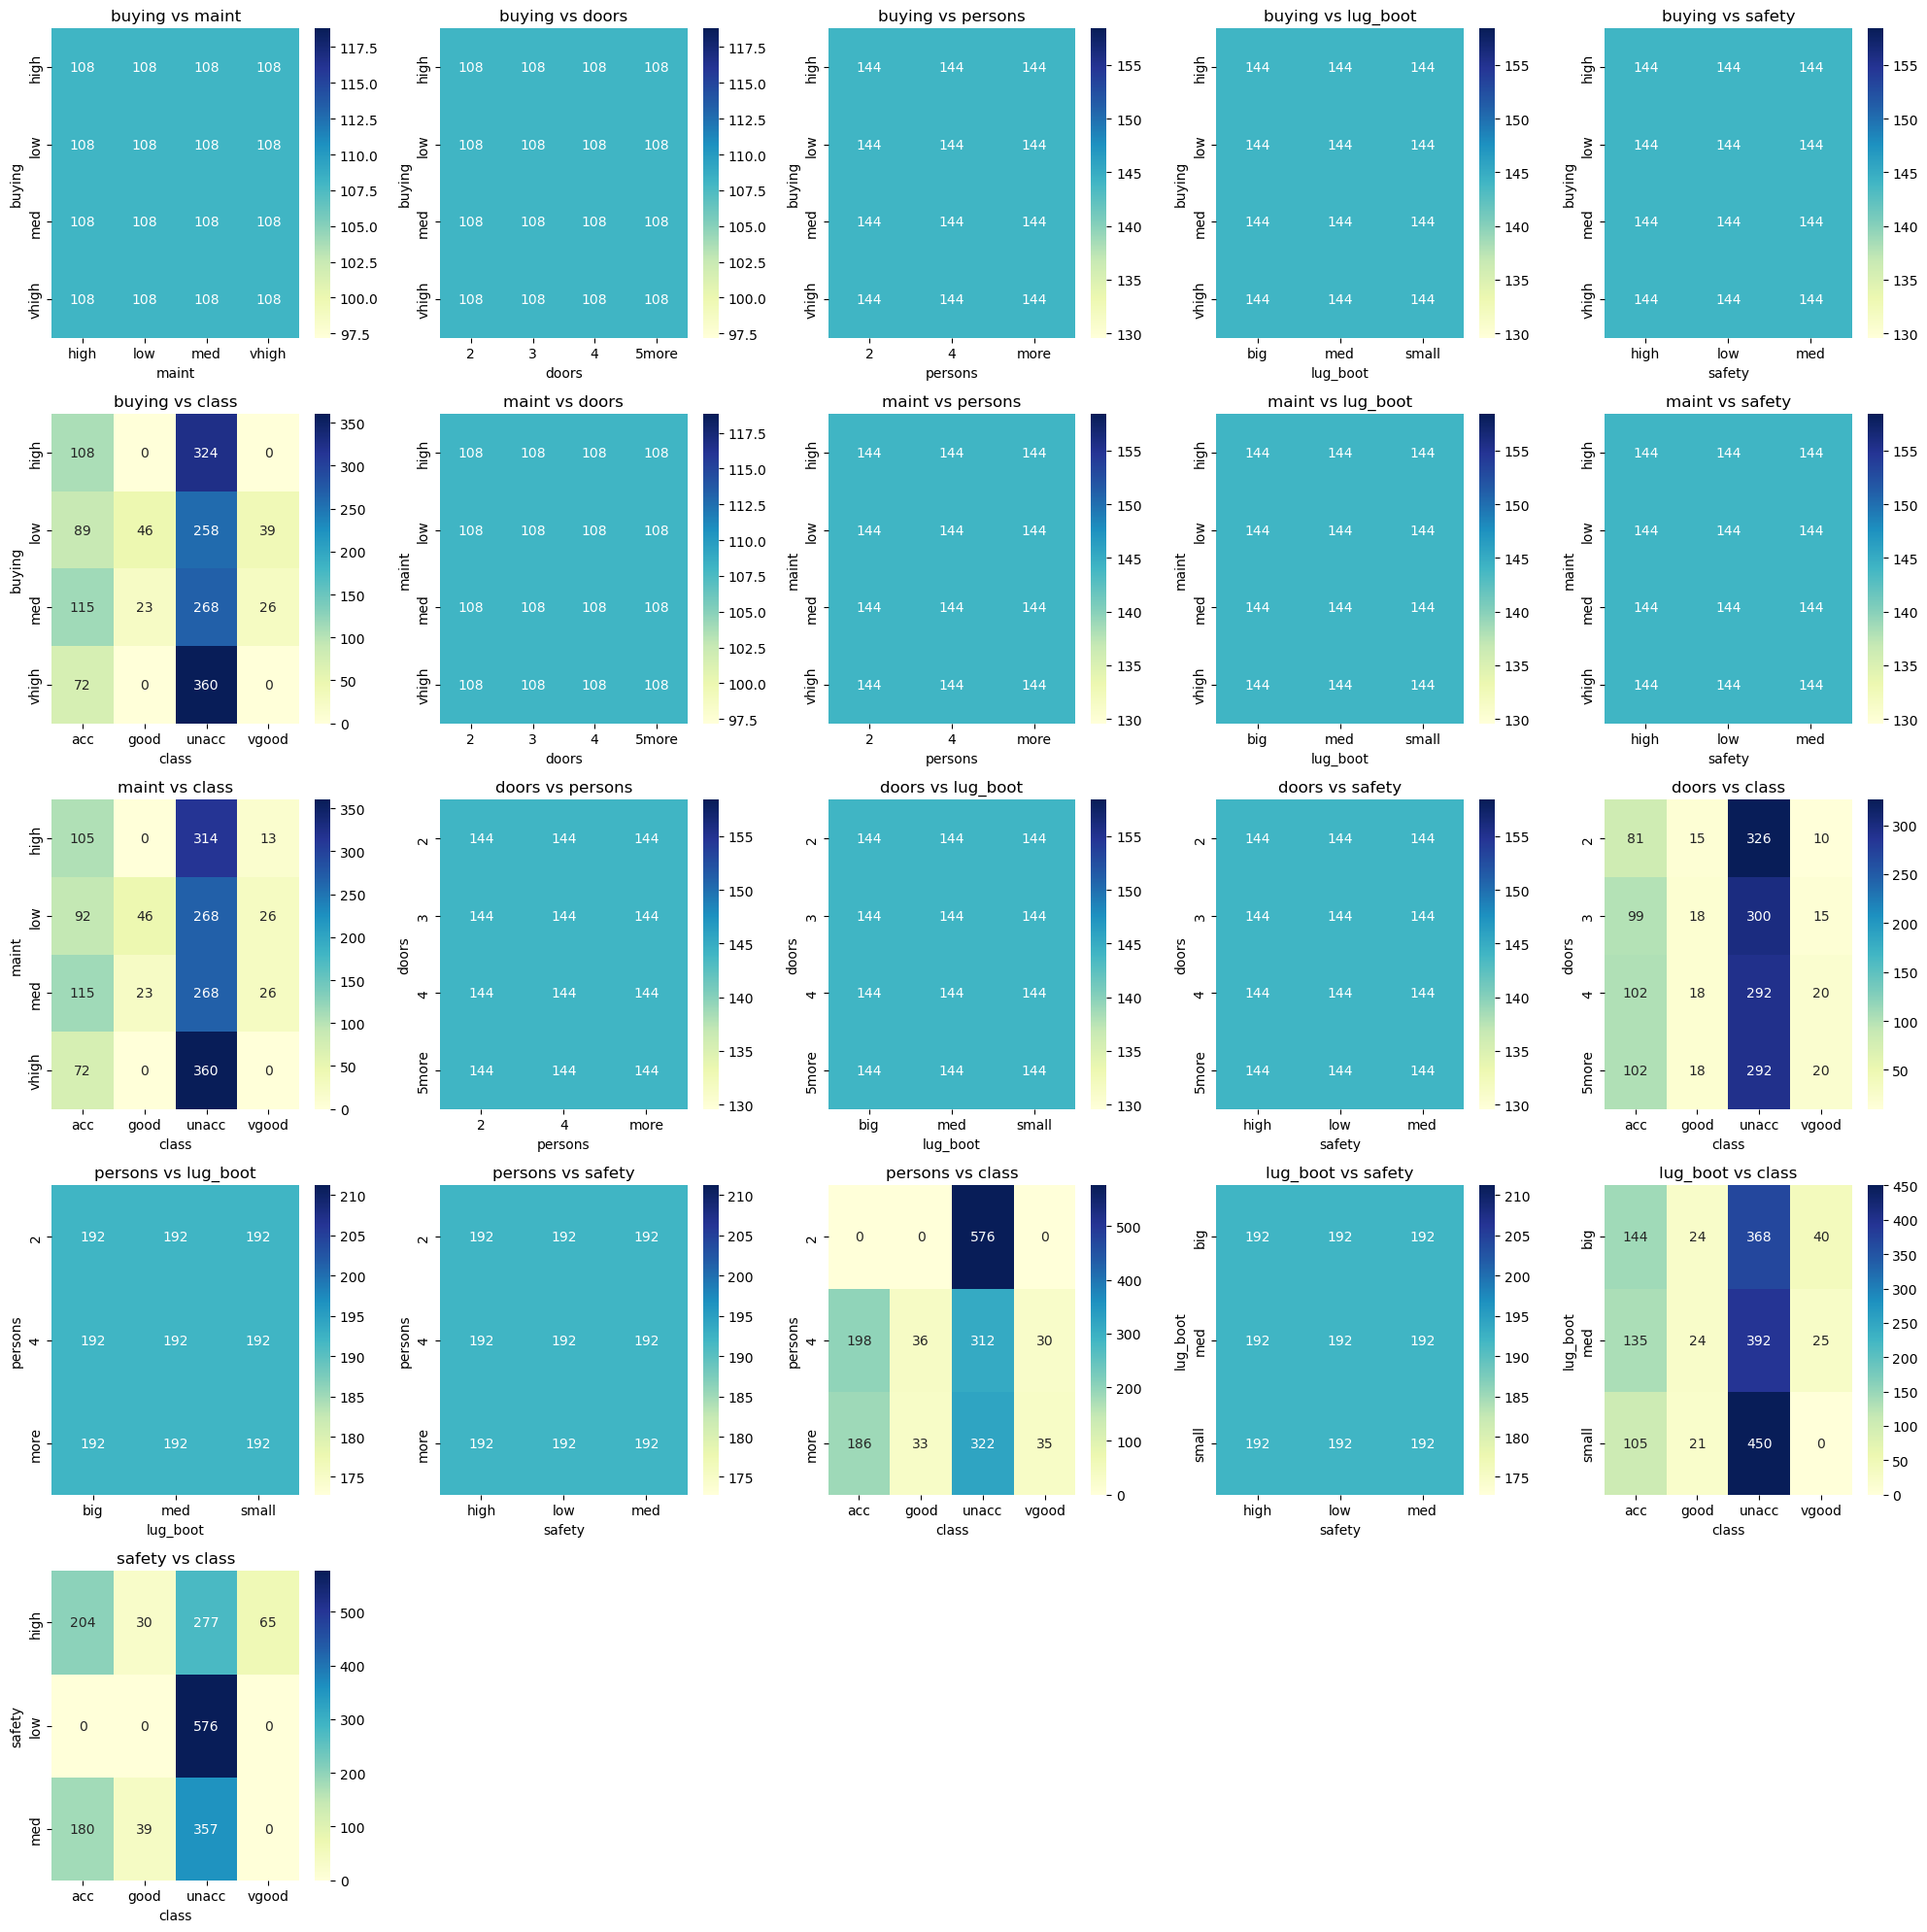

In [47]:
# Get all unique pairs of columns
columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
col_pairs = list(itertools.combinations(df.columns, 2))
n_pairs = len(col_pairs)

# Set up a grid of subplots
n_cols = 5
n_rows = math.ceil(n_pairs / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, (col1, col2) in enumerate(col_pairs):
    # Create a cross-tabulation (joint frequency) for the two columns
    ct = pd.crosstab(df[col1], df[col2])
    
    # Plot the heatmap with annotation
    sns.heatmap(ct, annot=True, fmt="d", cmap="YlGnBu", ax=axes[i])
    axes[i].set_title(f"{col1} vs {col2}")
    axes[i].set_xlabel(col2)
    axes[i].set_ylabel(col1)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

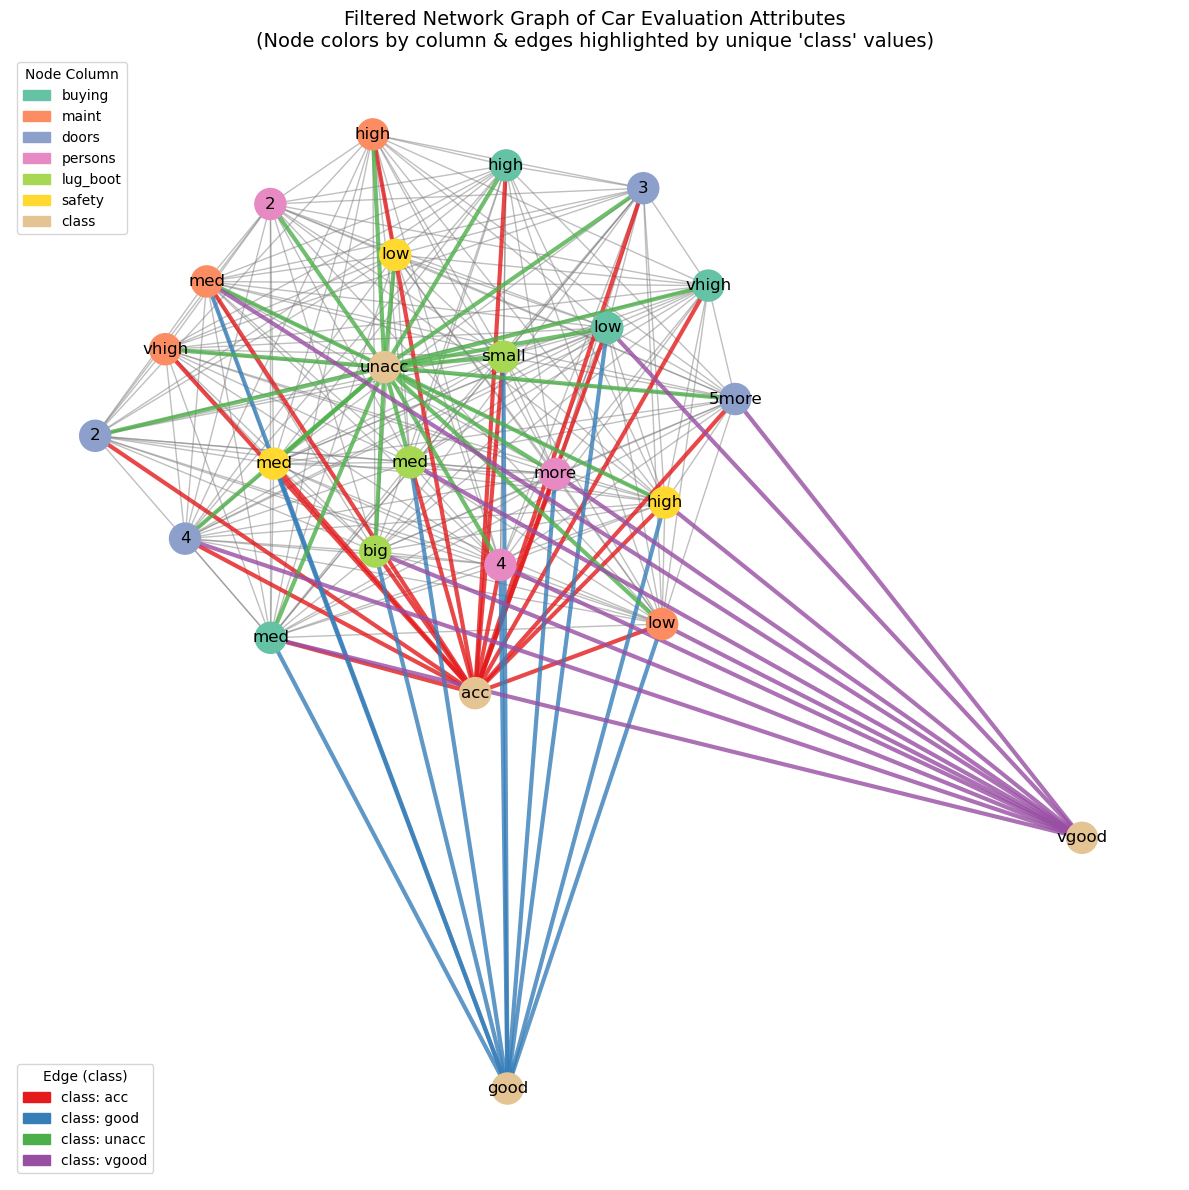

In [55]:
# Define a color palette for nodes based on column names
node_palette = sns.color_palette("Set2", n_colors=len(columns))
node_color_map = dict(zip(columns, node_palette))

# Build the full network graph: each node is a tuple (column, value)
G = nx.Graph()
for _, row in df.iterrows():
    attrs = [(col, row[col]) for col in columns]
    # Add nodes for each attribute in the row
    for attr in attrs:
        if attr not in G:
            G.add_node(attr)
    # Connect every pair of attributes from the same record (incrementing weight)
    for attr1, attr2 in itertools.combinations(attrs, 2):
        if G.has_edge(attr1, attr2):
            G[attr1][attr2]['weight'] += 1
        else:
            G.add_edge(attr1, attr2, weight=1)

# Filter out low-frequency edges to reduce clutter
threshold = 20  
edges_to_keep = [(u, v) for u, v, data in G.edges(data=True) if data['weight'] >= threshold]
H = nx.Graph()
H.add_nodes_from(G.nodes(data=True))
H.add_edges_from((u, v, G[u][v]) for u, v in edges_to_keep)
# Remove isolated nodes, if any
isolated = list(nx.isolates(H))
if isolated:
    H.remove_nodes_from(isolated)

# --- Separate edges based on 'class' association ---
# For each edge, if one of its endpoints belongs to 'class', group it by that unique class value.
unique_classes = sorted(df['class'].unique())
edge_class_groups = {cls: [] for cls in unique_classes}
normal_edges = []
for u, v, data in H.edges(data=True):
    if u[0] == 'class':
        edge_class_groups[u[1]].append((u, v))
    elif v[0] == 'class':
        edge_class_groups[v[1]].append((u, v))
    else:
        normal_edges.append((u, v))

# --- Determine node colors ---
node_colors = [node_color_map[node[0]] for node in H.nodes()]

# --- Create a color palette for edges based on unique 'class' values ---
edge_palette = sns.color_palette("Set1", n_colors=len(unique_classes))
edge_color_map = dict(zip(unique_classes, edge_palette))

# --- Plot the network graph ---
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(H, k=0.5, seed=42)

# Draw nodes (colored by originating column)
nx.draw_networkx_nodes(H, pos, node_size=500, node_color=node_colors)

# Draw normal edges in light gray
nx.draw_networkx_edges(H, pos, edgelist=normal_edges, width=1, alpha=0.5, edge_color='gray')

# Draw edges connected to 'class' nodes with colors based on the unique class value
for cls, edgelist in edge_class_groups.items():
    nx.draw_networkx_edges(H, pos, edgelist=edgelist, width=3, alpha=0.8,
                           edge_color=[edge_color_map[cls]] * len(edgelist))

# Draw labels (show only the attribute value, i.e. second element of tuple)
labels = {node: node[1] for node in H.nodes()}
nx.draw_networkx_labels(H, pos, labels, font_size=12)

# --- Create legends ---
# Legend for node colors (by column)
node_handles = [mpatches.Patch(color=node_color_map[col], label=col) for col in node_color_map]
node_legend = plt.legend(handles=node_handles, title="Node Column", loc="upper left")
plt.gca().add_artist(node_legend)

# Legend for edge colors (by unique 'class' value)
edge_handles = [mpatches.Patch(color=edge_color_map[cls], label=f"class: {cls}") for cls in unique_classes]
plt.legend(handles=edge_handles, title="Edge (class)", loc="lower left")

plt.title("Filtered Network Graph of Car Evaluation Attributes\n(Node colors by column & edges highlighted by unique 'class' values)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()